In [1]:
import numpy as np
import pandas as pd
import pyodbc
import time
import pickle
import operator
from operator import itemgetter
from joblib import Parallel, delayed

from sklearn import linear_model

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
%matplotlib inline

Before everything, please download a preprocessed version of the natality data from https://www.dropbox.com/s/395rrh0c826gw9r/Natality_small.csv?dl=0

In [2]:
conn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=localhost;"
                        "Database=master;"
                        "Trusted_Connection=yes;")

cur = conn.cursor()

engine = create_engine('mssql+pyodbc://localhost/master?driver=SQL+Server+Native+Client+11.0')

In [3]:
def construct_sec_order(arr):
    # data generation function helper.
    
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
        
    return np.array(second_order_feature)

def data_generation_dense_2(num_control, num_treated, num_cov_dense, num_covs_unimportant, 
                            control_m = 0.1, treated_m = 0.9):
    # the data generation function that I'll use.
    xc = np.random.binomial(1, 0.5, size=(num_control, num_cov_dense))   # data for conum_treatedrol group
    xt = np.random.binomial(1, 0.5, size=(num_treated, num_cov_dense))   # data for treatmenum_treated group
        
    errors1 = np.random.normal(0, 0.05, size=num_control)    # some noise
    errors2 = np.random.normal(0, 0.05, size=num_treated)    # some noise
    
    dense_bs_sign = np.random.choice([-1,1], num_cov_dense)
    #dense_bs = [ np.random.normal(dense_bs_sign[i]* (i+2), 1) for i in range(len(dense_bs_sign)) ]
    dense_bs = [ np.random.normal(s * 10, 1) for s in dense_bs_sign ]

    yc = np.dot(xc, np.array(dense_bs)) + errors1     # y for conum_treatedrol group 
    
    treatment_eff_coef = np.random.normal( 1.5, 0.15, size=num_cov_dense)
    treatment_effect = np.dot(xt, treatment_eff_coef) 
    
    second = construct_sec_order(xt[:,:5])
    treatment_eff_sec = np.sum(second, axis=1)
    
    yt = np.dot(xt, np.array(dense_bs)) + treatment_effect + treatment_eff_sec + errors2    # y for treated group 

    xc2 = np.random.binomial(1, control_m, size=(num_control, num_covs_unimportant))   #
    xt2 = np.random.binomial(1, treated_m, size=(num_treated, num_covs_unimportant))   #
        
    df1 = pd.DataFrame(np.hstack([xc, xc2]), 
                       columns=['{0}'.format(i) for i in range(num_cov_dense + num_covs_unimportant)])
    df1['outcome'] = yc
    df1['treated'] = 0

    df2 = pd.DataFrame(np.hstack([xt, xt2]), 
                       columns=['{0}'.format(i) for i in range(num_cov_dense + num_covs_unimportant )] ) 
    df2['outcome'] = yt
    df2['treated'] = 1

    df = pd.concat([df1,df2])
    df['matched'] = 0
  
    return df, dense_bs, treatment_eff_coef

In [4]:
# this function takes the current covariate list, the covariate we consider dropping, name of the data table, 
# name of the holdout table, the threshold (below which we consider as no match), and balancing regularization
# as input; and outputs the matching quality
def score_tentative_drop_c(cov_l, c, db_name, holdout_df, thres = 0, tradeoff = 0.1):
    
    covs_to_match_on = set(cov_l) - {c} # the covariates to match on
    
    # the flowing query fetches the matched results (the variates, the outcome, the treatment indicator)
    s = time.time()
    ##cur.execute('''with temp AS 
    ##    (SELECT 
    ##    {0}
    ##    FROM {3}
    ##    where "matched"=0
    ##    group by {0}
    ##    Having sum("treated")>'0' and sum("treated")<count(*) 
    ##    )
    ##    (SELECT {1}, {3}."treated", {3}."outcome"
    ##    FROM temp, {3}
    ##    WHERE {2}
    ##    )
    ##    '''.format(','.join(['"C{0}"'.format(v) for v in covs_to_match_on ]),
    ##               ','.join(['{1}."C{0}"'.format(v, db_name) for v in covs_to_match_on ]),
    ##               ' AND '.join([ '{1}."C{0}"=temp."C{0}"'.format(v, db_name) for v in covs_to_match_on ]),
    ##               db_name
    ##              ) )
    ##res = np.array(cur.fetchall())
    
    cur.execute('''with temp AS 
        (SELECT 
        {0}
        FROM {3}
        where "matched"=0
        group by {0}
        Having sum("treated")>'0' and sum("treated")<count(*) 
        )
        (SELECT {1}, treated, outcome
        FROM {3}
        WHERE EXISTS 
        (SELECT 1
        FROM temp 
        WHERE {2}
        )
        )
        '''.format(','.join(['"{0}"'.format(v) for v in covs_to_match_on ]),
                   ','.join(['{1}."{0}"'.format(v, db_name) for v in covs_to_match_on ]),
                   ' AND '.join([ '{1}."{0}"=temp."{0}"'.format(v, db_name) for v in covs_to_match_on ]),
                   db_name
                  ) )
    res = np.array(cur.fetchall())
    
    time_match = time.time() - s
    
    s = time.time()
    # the number of unmatched treated units
    cur.execute('''select count(*) from {} where "matched" = 0 and "treated" = 0'''.format(db_name))
    num_control = cur.fetchall()
    # the number of unmatched control units
    cur.execute('''select count(*) from {} where "matched" = 0 and "treated" = 1'''.format(db_name))
    num_treated = cur.fetchall()
    time_BF = time.time() - s
    
    # fetch from database the holdout set
    
    ##s = time.time()
    ##cur.execute('''select {0}, "treated", "outcome" 
    ##               from {1}
    ##            '''.format( ','.join( ['"C{0}"'.format(v) for v in covs_to_match_on ] ) , holdout))
    ##holdout = np.array(cur.fetchall())
    
    s = time.time() # the time for fetching data into memory is not counted if use this
    
    # below is the regression part for PE
    #ridge_c = Ridge(alpha=0.1)
    #ridge_t = Ridge(alpha=0.1)
    tree_c = DecisionTreeRegressor(max_depth=8, random_state=0)
    tree_t = DecisionTreeRegressor(max_depth=8, random_state=0)
    
    holdout = holdout_df.copy()
    holdout = holdout[ list(covs_to_match_on) + ['treated', 'outcome']]
        
    mse_t = np.mean(cross_val_score(tree_t, holdout[holdout['treated'] == 1].iloc[:,:-2], 
                                holdout[holdout['treated'] == 1]['outcome'] , scoring = 'neg_mean_squared_error' ) )
        
    mse_c = np.mean(cross_val_score(tree_c, holdout[holdout['treated'] == 0].iloc[:,:-2], 
                                holdout[holdout['treated'] == 0]['outcome'], scoring = 'neg_mean_squared_error' ) )
    
    #mse_t = np.mean(cross_val_score(ridge_t, holdout[holdout['treated'] == 1].iloc[:,:-2], 
    #                            holdout[holdout['treated'] == 1]['outcome'] , scoring = 'neg_mean_squared_error' ) )
        
    #mse_c = np.mean(cross_val_score(ridge_c, holdout[holdout['treated'] == 0].iloc[:,:-2], 
    #                            holdout[holdout['treated'] == 0]['outcome'], scoring = 'neg_mean_squared_error' ) )
    # above is the regression part for BF
    
    time_PE = time.time() - s
    
    if len(res) == 0:
        return (( mse_t + mse_c ), time_match, time_PE, time_BF)
        ##return mse_t + mse_c
    else:        
        return (tradeoff * (float(len(res[res[:,-2]==0]))/num_control[0][0] + float(len(res[res[:,-2]==1]))/num_treated[0][0]) +\
             ( mse_t + mse_c ), time_match, time_PE, time_BF)
        ##return reg_param * (float(len(res[res[:,-2]==0]))/num_control[0][0] + float(len(res[res[:,-2]==1]))/num_treated[0][0]) +\
        ##         ( mse_t + mse_c )

In [5]:
# update matched units
# this function takes the currcent set of covariates and the name of the database; and update the "matched"
# column of the newly mathced units to be "1"

def update_matched(covs_matched_on, db_name, level):
    
    cur.execute('''with temp AS 
        (SELECT 
        {0}
        FROM {3}
        where "matched"=0
        group by {0}
        Having sum("treated")>'0' and sum("treated")<count(*) 
        )
        update {3} set "matched"={4}
        WHERE EXISTS
        (SELECT {0}
        FROM temp
        WHERE {2} and {3}."matched" = 0
        )
        '''.format(','.join(['"{0}"'.format(v) for v in covs_matched_on]),
                   ','.join(['{1}."{0}"'.format(v, db_name) for v in covs_matched_on]),
                   ' AND '.join([ '{1}."{0}"=temp."{0}"'.format(v, db_name) for v in covs_matched_on ]),
                   db_name,
                   level
                  ) )
    conn.commit()
    
    return

In [6]:
# get CATEs 
# this function takes a list of covariates and the name of the data table as input and outputs a dataframe 
# containing the combination of covariate values and the corresponding CATE 
# and the corresponding effect (and the count and variance) as values

def get_CATE(cov_l, db_name, level):

    cur.execute(''' select {0}, avg(outcome * 1.0), count(*)
                    from {1}
                    where matched = {2} and treated = 0
                    group by {0}
                    '''.format(','.join(['"{0}"'.format(v) for v in cov_l]), 
                              db_name, level) )
    res_c = cur.fetchall()
    
    cur.execute(''' select {0}, avg(outcome * 1.0), count(*)
                    from {1}
                    where matched = {2} and treated = 1
                    group by {0}
                    '''.format(','.join(['"{0}"'.format(v) for v in cov_l]), 
                              db_name, level) )
    res_t = cur.fetchall()
            
    if (len(res_c) == 0) | (len(res_t) == 0):
        return None
    
    cov_l = list(cov_l)
    
    result = pd.merge(pd.DataFrame(np.array(res_c), columns=['{}'.format(i) for i in cov_l]+['effect_c', 'count_c']), 
                  pd.DataFrame(np.array(res_t), columns=['{}'.format(i) for i in cov_l]+['effect_t', 'count_t']), 
                  on = ['{}'.format(i) for i in cov_l], how = 'inner') 
    
    result_df = result[['{}'.format(i) for i in cov_l] + ['effect_c', 'effect_t', 'count_c', 'count_t']]
        
    # -- the following section are moved to after getting the result
    #d = {}
    #for i, row in result.iterrows():
    #    k = ()
    #    for j in range(len(cov_l)):
    #        k = k + ((cov_l[j], row[j]),)
    #    d[k] = (row['effect_c'], row['effect_t'], row['std_t'], row['std_c'], row['count_c'], row['count_t'])
    # -- the above section are moved to after getting the result
    
    return result_df

In [7]:
def run(db_name, holdout_df, num_covs, reg_param = 0.1):

    cur.execute('update {0} set matched = 0'.format(db_name)) # reset the matched indicator to 0
    conn.commit()

    covs_dropped = [] # covariate dropped
    ds = []
    
    level = 1

    timings = [0]*5 # first entry - match (groupby and join), 
                    # second entry - regression (compute PE), 
                    # third entry - compute BF, 
                    # fourth entry - keep track of CATE, 
                    # fifth entry - update database table (mark matched units). 
    
    cur_covs = range(num_covs) # initialize the current covariates to be all covariates
        
    # make predictions and save to disk
    s = time.time()
    update_matched(cur_covs, db_name, level) # match without dropping anything
    timings[4] = timings[4] + time.time() - s
        
    s = time.time()
    d = get_CATE(cur_covs, db_name, level) # get CATE without dropping anything
    timings[3] = timings[3] + time.time() - s
    
    ds.append(d)
    
    ##s = time.time()
    ##cur.execute('''update {} set "matched"=2 WHERE "matched"=1 '''.format(db_name)) # mark the matched units as matched and 
                                                                                    #they are no langer seen by the algorithm
    ##conn.commit()
    ##timings[4] = timings[4] + time.time() - s
    
    while len(cur_covs)>1:
        
        print(cur_covs) # print current set of covariates
        
        level += 1
        
        # the early stopping conditions
        cur.execute('''select count(*) from {} where "matched"=0 and "treated"=0'''.format(db_name))
        if cur.fetchall()[0][0] == 0:
            break
        cur.execute('''select count(*) from {} where "matched"=0 and "treated"=1'''.format(db_name))
        if cur.fetchall()[0][0] == 0:
            break
        
        best_score = -np.inf
        cov_to_drop = None
        
        cur_covs = list(cur_covs)
        for c in cur_covs:
            
            score,time_match,time_PE,time_BF = score_tentative_drop_c(cur_covs, c, db_name, 
                                                                      holdout_df, tradeoff = 0.1)
            
            timings[0] = timings[0] + time_match
            timings[1] = timings[1] + time_PE
            timings[2] = timings[2] + time_BF
            if score > best_score:
                best_score = score
                cov_to_drop = c

        cur_covs = set(cur_covs) - {cov_to_drop} # remove the dropped covariate from the current covariate set
        
        s = time.time()
        update_matched(cur_covs, db_name, level)
        timings[4] = timings[4] + time.time() - s
        
        s = time.time()
        d = get_CATE(cur_covs, db_name, level)
        timings[3] = timings[3] + time.time() - s
        
        ds.append(d)
        
        ##s = time.time()
        ##cur.execute('''update {} set "matched"=2 WHERE "matched"=1 '''.format(db_name))
        ##conn.commit()
        ##timings[4] = timings[4] + time.time() - s
        
        covs_dropped.append(cov_to_drop) # append the removed covariate at the end of the covariate
        
    return timings, ds

PGARScore as outcome

In [69]:
df = pd.read_csv('Natality_small.csv')

df = df[df['ABAssistedVentilation'] != 'U']

df = df[df['ABAssistedVentilationMoreThan6Hrs'] != 'U']

df = df[df['ABAdmissionToNICU'] != 'U']

df = df[df['ABSurfactant'] != 'U']

df = df[df['ABAntibiotics'] != 'U']

df = df[df['ABSeizures'] != 'U']

df = df.drop(columns=['FiveMinuteAPGARScoreRecode', 'DeliveryMethodRecodeRevised'])

In [72]:
df['outcome'] = df['FiveMinAPGARScore']
df = df[df['outcome'] != 99]

In [74]:
df = df.drop(columns=['FiveMinAPGARScore'])

In [75]:
df.loc[df['CigaretteRecode'] == 'Y', 'CigaretteRecode'] = 1
df.loc[df['CigaretteRecode'] == 'N', 'CigaretteRecode'] = 0

df['matched'] = 0

cols = [c for c in df.columns if c.lower()[:4] != 'flag']

df = df[cols]

In [76]:
char_col = []
for c in df.columns:    
    if df[c].dtype != np.int64:
        char_col.append(c)
        
for c in char_col:
    df[c] = df[c].astype(str)
    l = sorted(list(np.unique(df[c])))
    print c, l
    for i in range(len(l)):
        df.loc[df[c] == l[i], c] = i

RFPrepregnancyDiabetes ['N', 'U', 'Y']
RFGestationalDiabetes ['N', 'U', 'Y']
RFPrepregnancyHypertension ['N', 'U', 'Y']
RFGestationalHypertension ['N', 'U', 'Y']
RFEclampsia ['N', 'U', 'Y']
RFPreviousPretermBirth ['N', 'U', 'Y']
RFPoorPregnancyOutcome ['N', 'U', 'Y']
PreviousCesareanDeliveries ['N', 'U', 'Y']
OPCervicalCerclage ['N', 'U', 'Y']
OPTocolysis ['N', 'U', 'Y']
OPSuccessfulExternalCephalicVersion ['N', 'U', 'Y']
FailedExternalCephalicVersion ['N', 'U', 'Y']
ONPrematureMembraneRapture ['N', 'U', 'Y']
ONPrecipitousLabor ['N', 'U', 'Y']
ONProlongedLabor ['N', 'U', 'Y']
LDInductionOfLabor ['N', 'U', 'Y']
LDAugmentationOfLabor ['N', 'U', 'Y']
LDLDNonVertexPresentation ['N', 'U', 'Y']
LDSteroids ['N', 'U', 'Y']
LDAntibiotics ['N', 'U', 'Y']
LDChorioamnionitis ['N', 'U', 'Y']
LDMeconiumStaining ['N', 'U', 'Y']
LDFetalIntolerance ['N', 'U', 'Y']
LDAnesthesia ['N', 'U', 'Y']
MEAttemptedForceps ['N', 'U', 'Y']
MEAttemptedVacuum ['N', 'U', 'Y']
METrialOfLaborAttempted ['N', 'U', 'X', 'Y

In [77]:
rename_dict = dict()

cols = list(df.columns)

cols.remove('matched')
cols.remove('outcome')
cols.remove('CigaretteRecode')

for i in range(len(cols)):
    rename_dict[i] = cols[i]
    
rename_dict['treated'] = 'CigaretteRecode'

In [78]:
inv_rename_dict = {v:k for k,v in rename_dict.iteritems()}

import pickle

pickle.dump(rename_dict, open('natality_rename_dict_score', 'wb'))

df.rename(columns = inv_rename_dict, inplace = True)

from sklearn.model_selection import train_test_split

df, holdout = train_test_split(df, test_size = 0.1, random_state = 345)

df.to_csv('Natality_db_score.csv', index = False)
holdout.to_csv('Natality_holdout_score.csv', index = False)
#holdout = pd.read_csv('Natality_holdout.csv')
df.to_sql('natality_score', engine, chunksize=100)

del df

In [8]:
#df.to_sql('natality', engine, chunksize=100)

holdout = pd.read_csv('Natality_holdout_score.csv')

holdout.rename(columns = {str(i):i for i in range(166)}, inplace = True)

#del df

db_name = 'natality_score'

s = time.time()
res = run(db_name, holdout, 91) 
print (time.time() - s)

#pickle.dump(res, open('natality_cigar_score_res', 'wb'))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75

set([2, 3, 4, 6, 7, 8, 9, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 63, 64, 66, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90])
set([2, 3, 4, 6, 8, 9, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 63, 64, 66, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90])
set([2, 3, 4, 6, 8, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 63, 64, 66, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90])
set([2, 4, 6, 8, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 63, 64, 66, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 90]

set([34, 36, 76, 47, 48, 20, 86, 87, 56, 89, 28, 30])
set([34, 36, 76, 48, 20, 86, 87, 56, 89, 28, 30])
set([34, 36, 76, 48, 86, 87, 56, 89, 28, 30])
set([34, 36, 76, 48, 86, 87, 56, 89, 30])
20688.8760002


abnormality as outcome, with prenatal care start time used to define sub-populations.

In [100]:
df = pd.read_csv('Natality_small.csv')

df = df[df['ABAssistedVentilation'] != 'U']

df = df[df['ABAssistedVentilationMoreThan6Hrs'] != 'U']

df = df[df['ABAdmissionToNICU'] != 'U']

df = df[df['ABSurfactant'] != 'U']

df = df[df['ABAntibiotics'] != 'U']

df = df[df['ABSeizures'] != 'U']

df = df.drop(columns=['FiveMinuteAPGARScoreRecode', 'DeliveryMethodRecodeRevised'])

In [17]:
df['outcome'] = np.array((df['ABAssistedVentilation'] == 'Y' ) |\
    (df['ABAssistedVentilationMoreThan6Hrs'] == 'Y') |\
    (df['ABAdmissionToNICU'] == 'Y') |\
    (df['ABSurfactant'] == 'Y') |\
    (df['ABAntibiotics'] == 'Y') |\
    (df['ABSeizures'] == 'Y') )

In [18]:
df['outcome'] = df['outcome'].astype(int)

In [19]:
df = df.drop(columns = ['ABAssistedVentilation', 'ABAssistedVentilationMoreThan6Hrs', 
                   'ABAdmissionToNICU', 'ABSurfactant', 'ABAntibiotics', 'ABSeizures'])

In [20]:
df.loc[df['CigaretteRecode'] == 'Y', 'CigaretteRecode'] = 1
df.loc[df['CigaretteRecode'] == 'N', 'CigaretteRecode'] = 0

In [21]:
df['matched'] = 0

In [22]:
cols = [c for c in df.columns if c.lower()[:4] != 'flag']

In [23]:
df = df[cols]

In [24]:
char_col = []
for c in df.columns:    
    if df[c].dtype != np.int64:
        char_col.append(c)
        
for c in char_col:
    df[c] = df[c].astype(str)
    l = sorted(list(np.unique(df[c])))
    print c, l
    for i in range(len(l)):
        df.loc[df[c] == l[i], c] = i

RFPrepregnancyDiabetes ['N', 'U', 'Y']
RFGestationalDiabetes ['N', 'U', 'Y']
RFPrepregnancyHypertension ['N', 'U', 'Y']
RFGestationalHypertension ['N', 'U', 'Y']
RFEclampsia ['N', 'U', 'Y']
RFPreviousPretermBirth ['N', 'U', 'Y']
RFPoorPregnancyOutcome ['N', 'U', 'Y']
PreviousCesareanDeliveries ['N', 'U', 'Y']
OPCervicalCerclage ['N', 'U', 'Y']
OPTocolysis ['N', 'U', 'Y']
OPSuccessfulExternalCephalicVersion ['N', 'U', 'Y']
FailedExternalCephalicVersion ['N', 'U', 'Y']
ONPrematureMembraneRapture ['N', 'U', 'Y']
ONPrecipitousLabor ['N', 'U', 'Y']
ONProlongedLabor ['N', 'U', 'Y']
LDInductionOfLabor ['N', 'U', 'Y']
LDAugmentationOfLabor ['N', 'U', 'Y']
LDLDNonVertexPresentation ['N', 'U', 'Y']
LDSteroids ['N', 'U', 'Y']
LDAntibiotics ['N', 'U', 'Y']
LDChorioamnionitis ['N', 'U', 'Y']
LDMeconiumStaining ['N', 'U', 'Y']
LDFetalIntolerance ['N', 'U', 'Y']
LDAnesthesia ['N', 'U', 'Y']
MEAttemptedForceps ['N', 'U', 'Y']
MEAttemptedVacuum ['N', 'U', 'Y']
METrialOfLaborAttempted ['N', 'U', 'X', 'Y

In [25]:
rename_dict = dict()

cols = list(df.columns)

cols.remove('matched')
cols.remove('outcome')
cols.remove('CigaretteRecode')

for i in range(len(cols)):
    rename_dict[i] = cols[i]

In [26]:
rename_dict['treated'] = 'CigaretteRecode'

In [27]:
inv_rename_dict = {v:k for k,v in rename_dict.iteritems()}

In [28]:
import pickle

pickle.dump(rename_dict, open('natality_rename_dict_abnormality', 'wb'))

In [29]:
df.rename(columns = inv_rename_dict, inplace = True)

In [30]:
from sklearn.model_selection import train_test_split

df, holdout = train_test_split(df, test_size = 0.1, random_state = 345)

In [31]:
df.to_csv('Natality_db_abnormality.csv', index = False)
holdout.to_csv('Natality_holdout_abnormality.csv', index = False)
#holdout = pd.read_csv('Natality_holdout.csv')
df.to_sql('natality_abnormality', engine, chunksize=100)

In [39]:
holdout = pd.read_csv('Natality_holdout_abnormality.csv')

In [42]:
#df.to_sql('natality', engine, chunksize=100)

holdout = pd.read_csv('Natality_holdout_abnormality.csv')

holdout.rename(columns = {str(i):i for i in range(166)}, inplace = True)

#del df

db_name = 'natality_abnormality'

s = time.time()
res = run(db_name, holdout, 86) 
print (time.time() - s)

pickle.dump(res, open('natality_cigar_abnormality_res', 'wb'))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])
set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85

set([2, 6, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 63, 68, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85])
set([6, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 63, 68, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85])
set([6, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 68, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85])
set([6, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 68, 69, 71, 72, 73, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85])
set([6, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 4

In [7]:
res = pickle.load(open('natality_cigar_score_res', 'rb'))

rename_dict = pickle.load(open('natality_rename_dict_score'))

In [7]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    ave = np.average(values, weights=weights)
    var = np.average((values-ave)**2, weights=weights)  # Fast and numerically precise
    return (ave, np.sqrt(var))

In [41]:
g1_effect = []
g2_effect = []
g1_size = []
g2_size = []

for i in range(len(res[1])):
    print i
    r = res[1][i]
    if r is None:
        continue
    if '11' not in list(r.columns):
        break
    r_small = r[(r['11'] <= 2) ]
    r_large = r[(r['11'] >= 3) & (r['11'] <= 4) ]
    
    g1_effect = g1_effect + list(r_small['effect_t'] - r_small['effect_c'] ) 
    g1_size = g1_size + list(r_small['count_t'] + r_small['count_c'] ) 
    
    g2_effect = g2_effect + list( r_large['effect_t'] - r_large['effect_c'] ) 
    g2_size = g2_size + list( r_large['count_t'] + r_large['count_c'] ) 
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [42]:
g1_effect = [float(v) for v in g1_effect ]
g2_effect = [float(v) for v in g2_effect ]
g1_size = [float(v) for v in g1_size ]
g2_size = [float(v) for v in g2_size ]

In [43]:
g1_mean, g1_std = weighted_avg_and_std(np.array(g1_effect), np.array(g1_size) )
g2_mean, g2_std = weighted_avg_and_std(np.array(g2_effect), np.array(g2_size) )

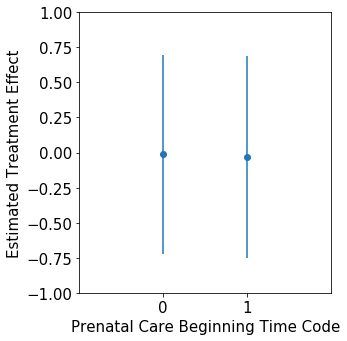

In [44]:
plt.rcParams['font.size'] = 15
plt.figure(figsize = (5,5))

plt.scatter([0,1], [g1_mean, g2_mean])
plt.errorbar([0,1], [g1_mean, g2_mean], yerr = [g1_std, g2_std], linestyle = 'None')

plt.xticks([0,1], ['0', '1'])

plt.xlabel('Prenatal Care Beginning Time Code') 
plt.ylabel('Estimated Treatment Effect') 
plt.xlim([-1,2])  
plt.ylim([-1,1])

plt.tight_layout() 
plt.savefig('natality_score_prenatal.png', dpi = 150) 

In [3]:
res = pickle.load(open('natality_cigar_score_res', 'rb'))

rename_dict = pickle.load(open('natality_rename_dict_score'))

In [4]:
effect = []
size = []

for i in range(len(res[1])):
    print i
    r = res[1][i]
    if r is None:
        continue
    
    effect = effect + list(r['effect_t'] - r['effect_c'] ) 
    size = size + list(r['count_t'] + r['count_c'] ) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [5]:
effect = [float(v) for v in effect ]
size = [float(v) for v in size ]

In [8]:
avr, std = weighted_avg_and_std(np.array(effect), np.array(size) )

In [50]:
g1_effect = []
g2_effect = []
g3_effect = []
g1_size = []
g2_size = []
g3_size = []

for i in range(len(res[1])):
    print i
    r = res[1][i]
    if r is None:
        continue
    if '11' not in list(r.columns):
        break
    #r1 = r[(r['6'] == 0) ]
    r2 = r[(r['7'] >=7) ]
    r3 = r[(r['7'] < 7)]
    
    #g1_effect = g1_effect + list(r1['effect_t'] - r1['effect_c'] ) 
    #g1_size = g1_size + list(r1['count_t'] + r1['count_c'] ) 
    
    g2_effect = g2_effect + list( r2['effect_t'] - r2['effect_c'] ) 
    g2_size = g2_size + list( r2['count_t'] + r2['count_c'] ) 
    
    g3_effect = g3_effect + list( r3['effect_t'] - r3['effect_c'] ) 
    g3_size = g3_size + list( r3['count_t'] + r3['count_c'] ) 
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [51]:
g1_effect = [float(v) for v in g1_effect ]
g2_effect = [float(v) for v in g2_effect ]
g3_effect = [float(v) for v in g3_effect ]
g1_size = [float(v) for v in g1_size ]
g2_size = [float(v) for v in g2_size ]
g3_size = [float(v) for v in g3_size ]

#g1_mean, g1_std = weighted_avg_and_std(np.array(g1_effect), np.array(g1_size) )
g2_mean, g2_std = weighted_avg_and_std(np.array(g2_effect), np.array(g2_size) )
g3_mean, g3_std = weighted_avg_and_std(np.array(g3_effect), np.array(g3_size) )

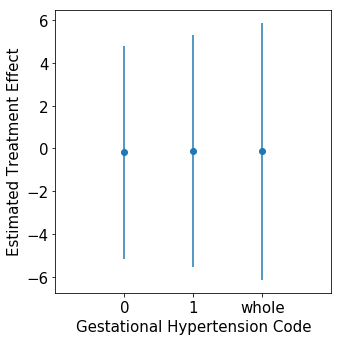

In [53]:
plt.rcParams['font.size'] = 15
plt.figure(figsize = (5,5))

plt.scatter([0,1,2], [g3_mean, g2_mean, avr])
plt.errorbar([0,1,2], [g3_mean, g2_mean, avr], yerr = [g3_std, g2_std, std], linestyle = 'None')

plt.xticks([0,1,2], ['0', '1', 'whole'])

plt.xlabel("Gestational Hypertension Code") 
plt.ylabel('Estimated Treatment Effect') 
plt.xlim([-1,3])  
#plt.ylim([-1,1])

plt.tight_layout() 
#plt.savefig('natality_score_hypertensions_whole.png', dpi = 150) 